In [1]:
import torch
from torch import nn, optim
import torchvision as vis
from torch.utils import data
import numpy as np
from tqdm import tqdm

import os, sys, json

has_cuda = torch.cuda.is_available()
# has_cuda = False
is_windows = sys.platform == "win32"

if has_cuda:
  print(torch.cuda.get_device_name(0))
else:
  print("CPU")
device = torch.device("cuda:0" if has_cuda else "cpu")

Tesla T4


In [2]:
import clip
# pip install git+https://github.com/openai/CLIP.git
clip_model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f9993ec91f0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [3]:
from model_helper import ModelSaver, load_model, model_store, StoredModel

In [4]:
from PIL import Image
import os
import numpy as np

class VideoFramesDataset(vis.datasets.VisionDataset):
  def __init__(self, root, transforms):
    self.categories = os.listdir(root)[:10]
    self.categories.sort()
    self.transcript_base = "/home/ubuntu/data1/transcriptions"
    
    self.videos = list()
    for cat_idx, category in tqdm(enumerate(self.categories), ncols=100, total=len(self.categories), desc="dir walk"):
      for video in sorted(os.listdir(f"{root}/{category}"))[:500]:
        frames = os.listdir(f"{root}/{category}/{video}")
        if len(frames) < 6:
          continue
        frames = frames[:6]
        frames.sort()
        self.videos.append((cat_idx, video, frames))
    
    self.root = root
    self.length = len(self.videos)
    self.transforms = transforms
        
  def __len__(self):
      return self.length
    
  def pil_loader(self, path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(f"{self.root}/{path}", 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

  def __getitem__(self, index):
    # only return frame-wise features for now
    cat_idx, video, frames = self.videos[index]
    video_path_base = f"{self.categories[cat_idx]}/{video}"
    
    images = [self.transforms(self.pil_loader(f"{video_path_base}/{frame}")) for frame in frames]
    
    with open(f"{self.transcript_base}/{video_path_base[:-4]}.txt") as file:
      text = file.readline().strip()
    
    return torch.stack(images, dim=1), len(images), clip.tokenize(text[:77]) # clip context length defaults to 77

  def collate_fn(batch):
    frames, lengths, texts = list(zip(*batch))
    return torch.cat(frames), lengths, texts

In [5]:
preprocess = vis.transforms.Compose([vis.transforms.Resize(224, interpolation=vis.transforms.InterpolationMode.BICUBIC),
                                             vis.transforms.CenterCrop(224),
                                             vis.transforms.ToTensor()])

In [6]:
dataset = VideoFramesDataset("/home/ubuntu/data1/extracted_frames", preprocess)

dir walk: 100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 86.90it/s]


In [7]:
class Swish(nn.Module):
    """https://arxiv.org/abs/1710.05941"""
    def forward(self, x):
        return x * x.sigmoid()
      
class ImageEncoder(nn.Module):
    """Parametrizes q(z|x).
    We will use this for every q(z|x_i) for all i.
    @param n_latents: integer
                      number of latent dimensions
    @param n_channels: integer [default: 3]
                       number of input channels
    """
    def __init__(self, n_latents, n_channels=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv3d(n_channels, 32, (3, 7, 7), (2, 4, 4), (1, 3, 3), bias=False),
            nn.BatchNorm3d(32),
            Swish(),
            nn.Conv3d(32, 64, (2, 4, 4), 2, (1, 2, 2), bias=False),
            nn.BatchNorm3d(64),
            Swish(),
            nn.Conv3d(64, 128, (2, 4, 4), 2, (1, 2, 2), bias=False),
            nn.BatchNorm3d(128),
            Swish(),
            nn.Conv3d(128, 256, (2, 4, 4), (1, 2, 2), 0, bias=False),
            nn.BatchNorm3d(256),
            Swish())
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, n_latents * 4),
            Swish(),
            nn.Dropout(p=0.1), 
            nn.Linear(n_latents * 4, n_latents * 2),
        )
        self.n_latents = n_latents

    def forward(self, x):
        n_latents = self.n_latents
        x = self.features(x)
        x = self.classifier(x)
        return x[:, :n_latents], x[:, n_latents:]


class ImageDecoder(nn.Module):
    """Parametrizes p(x|z).
    We will use this for every p(x_i|z) for all i.
    @param n_latents: integer
                      number of latent dimensions
    @param n_channels: integer [default: 3]
                       number of input channels
    """
    def __init__(self, n_latents, n_channels=3):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.Linear(n_latents, 256 * 6 * 6),
            Swish())
        self.hallucinate = nn.Sequential(
            nn.ConvTranspose3d(256, 128, (2, 4, 4), (1, 2, 2), 0, output_padding=(0, 1, 1), bias=False),
            nn.BatchNorm3d(128),
            Swish(),
            nn.ConvTranspose3d(128, 64, (2, 4, 4), 2, (1, 2, 2), output_padding=(1, 1, 1), bias=False),
            nn.BatchNorm3d(64),
            Swish(),
            nn.ConvTranspose3d(64, 32, (2, 4, 4), 2, (1, 2, 2), output_padding=(0, 1, 1), bias=False),
            nn.BatchNorm3d(32),
            Swish(),
            nn.ConvTranspose3d(32, n_channels, (3, 7, 7), (2, 4, 4), (1, 3, 3), bias=False)
        )

    def forward(self, z):
        # the input will be a vector of size |n_latents|
        z = self.upsample(z)
        z = z.view(-1, 256, 1, 6, 6)
        z = self.hallucinate(z)
        return z  # no sigmoid!

class VAE3D(nn.Module):
    def __init__(self, n_latents=512,
                 beta: int = 4,
                 gamma:float = 1000.,
                 max_capacity: int = 25,
                 capacity_max_iter: int = 1e5,
                 loss_type:str = 'H',):
        super().__init__()
        # define q(z|x_i) for i = 1...6
        self.image_encoder     = ImageEncoder(n_latents, 3)
        # define p(x_i|z) for i = 1...6
        self.image_decoder     = ImageDecoder(n_latents, 3)
        # define q(z|x) = q(z|x_1)...q(z|x_6)
        self.n_latents = n_latents
        self.bce_logit_loss = nn.BCEWithLogitsLoss(reduction='sum')
        self.num_iter = 0
        self.beta = beta
        self.gamma = gamma
        self.loss_type = loss_type
        self.C_max = torch.Tensor([max_capacity])
        self.C_stop_iter = capacity_max_iter

    def reparametrize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:  # return mean during inference
            return mu

    def forward(self, image):
        mu, logvar = self.image_encoder(image)
        # reparametrization trick to sample
        z = self.reparametrize(mu, logvar)
        # reconstruct inputs based on sample
        image_recon = self.image_decoder(z)
        
        self.current_mu = mu
        self.current_log_var = logvar
        self.current_latent = z

        return image_recon
      
    def loss(self, data_in, data_recon, kld_weight=1.0):
        # kld_weight: Account for the minibatch samples from the dataset
        self.num_iter += 1
        recons = data_recon
        input = data_in
        mu = self.current_mu
        log_var = self.current_log_var
        
        # since the image value is normalized between 0~1, BCE loss is better
        batch_size = recons.shape[0]
        recons_loss = self.bce_logit_loss(recons, input) / batch_size / 10 # a constant to reduce recon influcence
  
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        if self.loss_type == 'H': # https://openreview.net/forum?id=Sy2fzU9gl
            loss = recons_loss + self.beta * kld_weight * kld_loss
        elif self.loss_type == 'B': # https://arxiv.org/pdf/1804.03599.pdf
            self.C_max = self.C_max.to(input.device)
            C = torch.clamp(self.C_max/self.C_stop_iter * self.num_iter, 0, self.C_max.data[0])
            loss = recons_loss + self.gamma * kld_weight * (kld_loss - C).abs()
        else:
            raise ValueError('Undefined loss type.')

        return {'loss': loss, 'Reconstruction_Loss':recons_loss.item(), 'KLD':kld_loss.item()}

In [29]:
from torchinfo import summary
model_id = "test_model_02_embedding_loss"

def init_weights(model):
    torch.nn.init.kaiming_uniform_(model.weight)
    model.bias.data.fill_(0.0)

model = VAE3D(512, loss_type="B", beta=2.5)

print(model)

epoch_start = 1
# model.apply(init_weights)
model.to(device)
model_spec = str(summary(model, (2, 3, 6, 224, 224)))
print(model_spec)

VAE3D(
  (image_encoder): ImageEncoder(
    (features): Sequential(
      (0): Conv3d(3, 32, kernel_size=(3, 7, 7), stride=(2, 4, 4), padding=(1, 3, 3), bias=False)
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Swish()
      (3): Conv3d(32, 64, kernel_size=(2, 4, 4), stride=(2, 2, 2), padding=(1, 2, 2), bias=False)
      (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Swish()
      (6): Conv3d(64, 128, kernel_size=(2, 4, 4), stride=(2, 2, 2), padding=(1, 2, 2), bias=False)
      (7): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Swish()
      (9): Conv3d(128, 256, kernel_size=(2, 4, 4), stride=(1, 2, 2), bias=False)
      (10): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Swish()
    )
    (classifier): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=921

In [11]:
try:
  os.mkdir(f"{model_store}/{model_id}")
except:
  print("WARNING: directory exists")
# save model summary to a txt file
with open(f"{model_store}/{model_id}/model_spec.txt", "w") as file:
  file.write(str(model) + "\n")
  file.write(model_spec.replace("├─", "|-"))

In [8]:
model_id = "test_model_02_embedding_loss"
epoch_start, model, optimizer, scheduler, criterion = load_model(model_id, device)

resuming from last checkpoint epoch_60


In [9]:
model_id = "test_model_02_embedding_loss_weighted_full_10_cat"

In [48]:
os.mkdir(f"{model_store}/{model_id}")
# save model summary to a txt file
with open(f"{model_store}/{model_id}/model_spec.txt", "w") as file:
  file.write(str(model) + "\n")

In [10]:
train_dataloader_args = dict(batch_size=32,
                             num_workers=8 if not is_windows else 0) if has_cuda else dict(batch_size=64)
train_dataloader_args["shuffle"] = True

validation_dataloader_args = train_dataloader_args.copy()
validation_dataloader_args["shuffle"] = False

train_dataloader = data.DataLoader(dataset, **train_dataloader_args)
validation_dataloader = data.DataLoader(dataset, **validation_dataloader_args)

In [11]:
def run_model(model, dataloader):
  text_sim_loss = nn.MSELoss(reduction='sum')
  
  cumulative_stats = {
    "loss": 0.0,
    "Reconstruction_Loss": 0.0,
    "KLD": 0.0,
    "text_similarity": 0.0
  }
  
  num_batches = 0
  
  prog_bar = tqdm(dataloader, desc="Train" if model.training else "Eval ")

  for video, _, text in prog_bar:
    video = video.to(device)
    text = text.squeeze().to(device)
    
    num_batches += 1
    batch_size = video.shape[0]
    
    if model.training:
      optimizer.zero_grad() # clear calculated gradients
    
    with torch.no_grad():
      text_embedding = clip_model.encode_text(text)

    with torch.cuda.amp.autocast():
      output = model(video)[:, :, :-1, :-1, :-1] #slice off the additional dimension
      losses = model.loss(video, output, 0.1)
      
    # custom loss function
    text_loss = text_sim_loss(model.current_latent,
                              text_embedding
                              # ,torch.ones(batch_size, dtype=torch.long, device=device)
                             ) / batch_size
    
    loss = losses["loss"] + text_loss * 10
    
    if model.training:        
      # backprop loss
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
      
    # accumulate and display stats
    cumulative_stats["loss"] += loss.item()
    cumulative_stats["Reconstruction_Loss"] += losses["Reconstruction_Loss"]
    cumulative_stats["KLD"] += losses["KLD"]
    cumulative_stats["text_similarity"] += text_loss.item()
    
    prog_bar.set_postfix(loss=f'{cumulative_stats["loss"] / num_batches:.6f}',
                         recon=f'{cumulative_stats["Reconstruction_Loss"] / num_batches:.6f}',
                         kld=f'{cumulative_stats["KLD"] / num_batches:.6f}',
                         text=f'{cumulative_stats["text_similarity"] / num_batches:.6f}',
                         lr=f'{optimizer.param_groups[0]["lr"]:.6f}')
  
  # average stats across batches
  cumulative_stats["loss"] /= len(dataloader)
  
  return cumulative_stats

In [12]:
from itertools import chain

num_epochs = 400

if epoch_start == 1:
  # define only at the start of the training
  print("New Model")
  
  regularization = 1e-4
  learning_rate = 1e-3
  optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=regularization)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma = 0.5)
else:
  print("Existing Model")

scaler = torch.cuda.amp.GradScaler() # mix-precision training
model_saver = ModelSaver(model_id, mode="min", regular_save_interval=5)

with open(f"{model_store}/{model_id}/training_params.txt", "w") as file:
  file.write(f"num_epochs = {num_epochs}\n")
  # file.write(f"criterion = {criterion}\n")
  file.write(f"optimizer = {optimizer}\n")
  file.write(f"scheduler = {type(scheduler).__name__}({scheduler.state_dict()})\n")

Existing Model


In [ ]:
from tqdm import tqdm
import sys
import json

print(f"Model: {model_id}. Training for {num_epochs} epochs", file=sys.stderr)

for epoch in range(epoch_start, num_epochs + 1):
  print(f"Epoch {epoch}", file=sys.stderr)
  
  # set model in training mode
  model.train()
  train_stats = run_model(model, train_dataloader)
  
  # let scheduler know it's the next epoch
#   scheduler.step(eval_stats["accuracy"])
  # scheduler.step()
  
  stats = {
    "epoch": epoch,
    "train_stats": train_stats,
    # "eval_stats": eval_stats,
    "learning rate": optimizer.param_groups[0]["lr"]
  }
    
  model_saver.save(StoredModel(model, optimizer, scheduler, None), stats, train_stats["loss"])

In [14]:
import matplotlib.pyplot as plt

def show_video(video):
  fig, axs = plt.subplots(1, 6, figsize=(15,7))
  
  for idx in range(video.shape[1]): 
    axs[idx].imshow(video[:, idx].permute(1,2,0))
    axs[idx].axis('off')
  
  plt.show()

In [18]:
model_id = "test_model_02_embedding_loss_weighted_full_10_cat"
_, model, _, _, _ = load_model(model_id, device, 170)

resuming from last checkpoint epoch_170


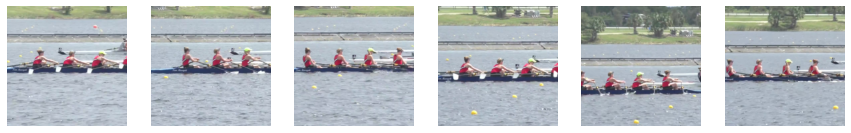

In [26]:
show_video(dataset[2786][0])

In [27]:
model.eval()

with torch.no_grad():
  res = model(dataset[2786][0].unsqueeze(0).to(device))

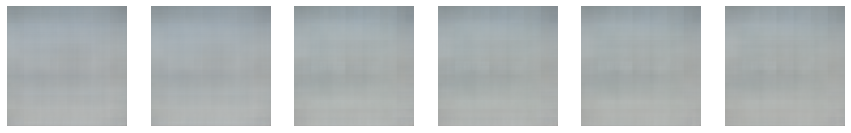

In [28]:
show_video(res[0, :, :-1, :-1, :-1].sigmoid().cpu())

In [31]:
video_embeddings = list()
text_embeddings = list()
model.eval()

with torch.no_grad():
  for frames, lengths, text in tqdm(train_dataloader, ncols=100, desc="Eval"):
    frames = frames.to(device)
    text = text.squeeze().to(device)
    text_embeddings.append(clip_model.encode_text(text))
    frame_embeddings = model.reparametrize(*model.image_encoder(frames))

    video_embeddings.append(frame_embeddings)
    
video_embeddings = torch.cat(video_embeddings).cpu()
text_embeddings = torch.cat(text_embeddings).cpu()

Eval: 100%|███████████████████████████████████████████████████████| 387/387 [03:00<00:00,  2.14it/s]


In [32]:
# image-text similarity
# weighted loss function with full 10 cat datasets

image_text_sim = nn.CosineSimilarity()(video_embeddings, text_embeddings)

print(f"{image_text_sim.mean().item():.4f}, {image_text_sim.std().item(): .4f}")

0.3204,  0.1105


In [35]:
# intra-category image similarity using centroid
# without text loss
start = 0

for cat, count in zip(cats, counts):
  cat_centroid = video_embeddings[start: start + count].mean(dim=0)
  intra_cat_sim = nn.CosineSimilarity()(cat_centroid.expand(count, -1), video_embeddings[start: start + count])
  inter_cat_sim_1 = nn.CosineSimilarity()(cat_centroid.expand(start, -1), video_embeddings[0:start])
  inter_cat_sim_2 = nn.CosineSimilarity()(cat_centroid.expand(video_embeddings.shape[0]-count-start, -1),
                                          video_embeddings[start + count:])
  inter_cat_sim = torch.cat([inter_cat_sim_1, inter_cat_sim_2])
  
  print(f"{cat}, {intra_cat_sim.mean().item():.4f}, {intra_cat_sim.std().item():.4f}, {inter_cat_sim.mean().item():.4f}, {inter_cat_sim.std().item():.4f}")
  start += count

0, 0.4081, 0.1372, 0.4075, 0.1378
1, 0.4086, 0.1401, 0.4063, 0.1372
2, 0.4072, 0.1376, 0.4070, 0.1378
3, 0.4056, 0.1347, 0.4071, 0.1381
4, 0.4033, 0.1342, 0.4080, 0.1398
5, 0.4145, 0.1391, 0.4062, 0.1366
6, 0.4164, 0.1406, 0.4051, 0.1425
7, 0.3884, 0.1247, 0.4047, 0.1381
8, 0.4115, 0.1420, 0.4066, 0.1404
9, 0.4065, 0.1391, 0.4060, 0.1374


In [48]:
# image-text similarity

image_text_sim = nn.CosineSimilarity()(video_embeddings, text_embeddings)

print(f"{image_text_sim.mean().item():.4f}, {image_text_sim.std().item(): .4f}")

0.0065,  0.0324


In [34]:
cats, counts = np.unique([v[0] for v in dataset.videos],
                         return_index=False, return_inverse=False, return_counts=True, axis=None)

In [42]:
# intra-category image similarity using centroid
# without text loss
start = 0

for cat, count in zip(cats, counts):
  cat_centroid = video_embeddings[start: start + count].mean(dim=0)
  intra_cat_sim = nn.CosineSimilarity()(cat_centroid.expand(count, -1), video_embeddings[start: start + count])
  inter_cat_sim_1 = nn.CosineSimilarity()(cat_centroid.expand(start, -1), video_embeddings[0:start])
  inter_cat_sim_2 = nn.CosineSimilarity()(cat_centroid.expand(video_embeddings.shape[0]-count-start, -1),
                                          video_embeddings[start + count:])
  inter_cat_sim = torch.cat([inter_cat_sim_1, inter_cat_sim_2])
  
  print(f"{cat}, {intra_cat_sim.mean().item():.4f}, {intra_cat_sim.std().item():.4f}, {inter_cat_sim.mean().item():.4f}, {inter_cat_sim.std().item():.4f}")
  start += count

0, 0.2137, 0.2063, 0.2120, 0.2381
1, 0.4060, 0.2682, 0.1652, 0.2627
2, 0.3745, 0.3247, 0.1738, 0.3076
3, 0.2595, 0.3028, 0.1839, 0.2841
4, 0.3467, 0.2326, 0.2533, 0.2206
5, 0.3121, 0.2135, 0.2551, 0.2229
6, 0.2660, 0.2201, 0.2039, 0.2461
7, 0.2925, 0.2562, 0.1888, 0.2972
8, 0.2891, 0.2187, 0.2511, 0.1994
9, 0.4404, 0.2528, 0.1650, 0.2777


In [39]:
# intra-category image similarity using centroid
# with text loss
start = 0

for cat, count in zip(cats, counts):
  cat_centroid = video_embeddings[start: start + count].mean(dim=0)
  intra_cat_sim = nn.CosineSimilarity()(cat_centroid.expand(count, -1), video_embeddings[start: start + count])
  inter_cat_sim_1 = nn.CosineSimilarity()(cat_centroid.expand(start, -1), video_embeddings[0:start])
  inter_cat_sim_2 = nn.CosineSimilarity()(cat_centroid.expand(video_embeddings.shape[0]-count-start, -1),
                                          video_embeddings[start + count:])
  inter_cat_sim = torch.cat([inter_cat_sim_1, inter_cat_sim_2])
  
  print(f"{cat}, {intra_cat_sim.mean().item():.4f}, {intra_cat_sim.std().item():.4f}, {inter_cat_sim.mean().item():.4f}, {inter_cat_sim.std().item():.4f}")
  start += count

0, 0.2850, 0.1532, 0.2666, 0.1645
1, 0.4265, 0.2198, 0.2208, 0.2333
2, 0.3585, 0.2262, 0.2187, 0.2049
3, 0.2772, 0.1650, 0.2412, 0.1621
4, 0.4044, 0.1872, 0.2940, 0.1967
5, 0.3457, 0.1652, 0.2975, 0.1611
6, 0.3161, 0.1620, 0.2565, 0.1856
7, 0.3042, 0.1568, 0.2395, 0.1781
8, 0.3518, 0.1507, 0.2893, 0.1639
9, 0.4634, 0.2400, 0.2229, 0.2560


In [34]:
from sklearn.manifold import TSNE

tsne_embedded = TSNE(n_components=2, n_jobs=8,
                     learning_rate="auto", init="pca").fit_transform(video_embeddings)

/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


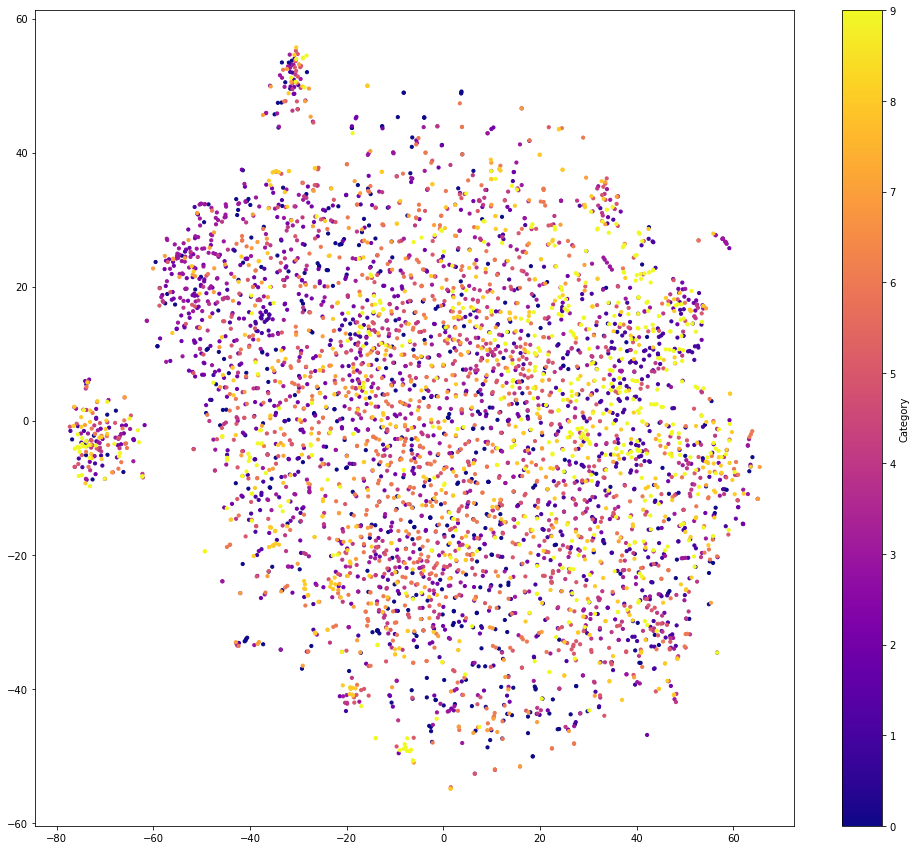

In [17]:
# no text loss
from matplotlib import pyplot as plt

fig = plt.figure(1, (17., 15.))
plt.scatter(tsne_embedded[:, 0], tsne_embedded[:, 1], alpha=1.0, s=10,
            c=[v[0] for v in dataset.videos], cmap="plasma")
cb = plt.colorbar()
cb.set_label('Category')

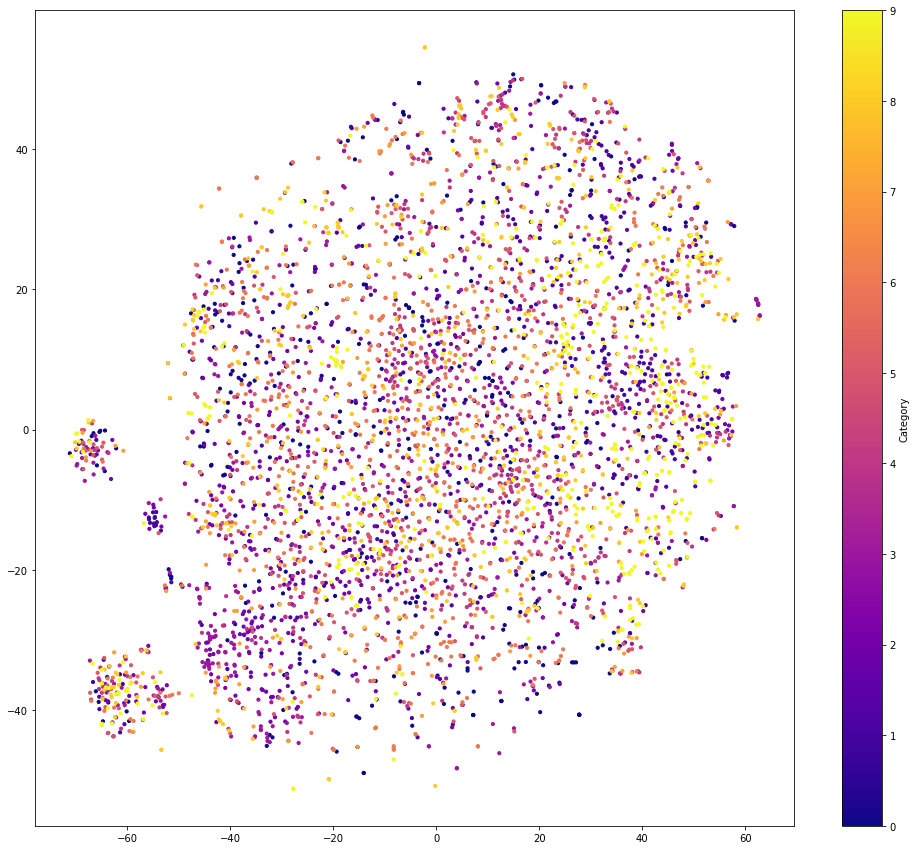

In [35]:
# with text loss
from matplotlib import pyplot as plt

fig = plt.figure(1, (17., 15.))
plt.scatter(tsne_embedded[:, 0], tsne_embedded[:, 1], alpha=1.0, s=10,
            c=[v[0] for v in dataset.videos], cmap="plasma")
cb = plt.colorbar()
cb.set_label('Category')